# Glucose to A1C Conversion

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp


### Conversion table

In [2]:
# Defining data for the dataframe
# A1C to Glucose conversion table
# A1c is in percentage
# Glucose is in mg/dL of the average glucose over the past 2-3 months
a1c_glucose = {
    'A1C': [4.0, 4.1,  4.2, 4.3,  4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.3, 8.5, 9.0, 9.5, 10, 11, 12, 13, 14, 15],
    'Glucose': [65, 69 , 72, 76, 79, 83, 86, 90, 93, 97, 101, 104, 108, 111, 115, 118, 122, 126, 129, 133, 136, 140, 143, 147, 151, 154, 158, 161, 165, 168, 172, 176, 180, 183, 186, 190, 193, 197, 200, 204, 207, 211, 218, 225, 243, 261, 279, 314,350, 386,421,457]
}

# Creating the dataframe
df = pd.DataFrame(a1c_glucose)

print(df.head())

   A1C  Glucose
0  4.0       65
1  4.1       69
2  4.2       72
3  4.3       76
4  4.4       79


### Data Visualization

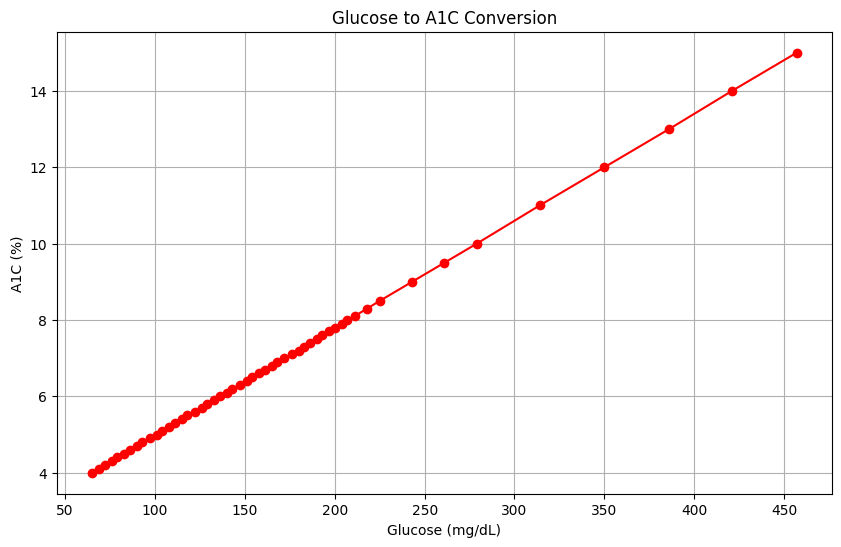

In [3]:
# Plotting Glucose vs. A1C
plt.figure(figsize=(10, 6))
plt.plot(df['Glucose'], df['A1C'], marker='o', linestyle='-', color='r')
plt.title('Glucose to A1C Conversion')
plt.xlabel('Glucose (mg/dL)')
plt.ylabel('A1C (%)')
plt.grid(True)
plt.show()

### Function Fitting

In [4]:
# Define the model function to be fitted to the data
def model_func(x, a, b, c):
    return a * x ** 2 + b * x  + c

### Curve fitting

In [5]:
# Convert columna to NumPy array
a1c = np.array(df['A1C'])
glucose = np.array(df['Glucose'])

In [6]:
# Use curve_fit to find the optimal parameters
glucose_a1c_params, params_covariance = curve_fit(model_func, glucose, a1c,  maxfev=500000000)
standard_errors = np.sqrt(np.diag(params_covariance))
print("Fitted Parameters:")
print(glucose_a1c_params)
print("\nStandard Errors of Parameters:")
print(standard_errors)
print("\nCovariance Matrix:")
print(params_covariance)

Fitted Parameters:
[7.04381209e-09 2.80681669e-02 2.17484707e+00]

Standard Errors of Parameters:
[1.19781126e-07 5.80394403e-05 5.91268150e-03]

Covariance Matrix:
[[ 1.43475180e-14 -6.73303620e-12  6.24395217e-10]
 [-6.73303620e-12  3.36857663e-09 -3.28981468e-07]
 [ 6.24395217e-10 -3.28981468e-07  3.49598025e-05]]


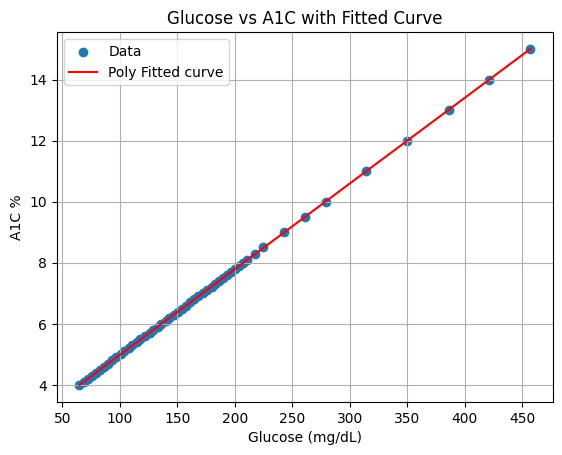

In [7]:
# Plot the data and the fitted curve
plt.scatter(glucose, a1c, label='Data')
plt.plot(glucose, model_func(glucose, *glucose_a1c_params), label='Poly Fitted curve', color='red')
plt.legend()
plt.xlabel('Glucose (mg/dL)')
plt.ylabel('A1C %')
plt.title('Glucose vs A1C with Fitted Curve')
plt.grid(True)
plt.show()

Root Mean Squared Error (RMSE): 0.008839 %
Error's Standard Deviation: 0.004959 %
Error's Uncertainty Percent: 56.103979 %


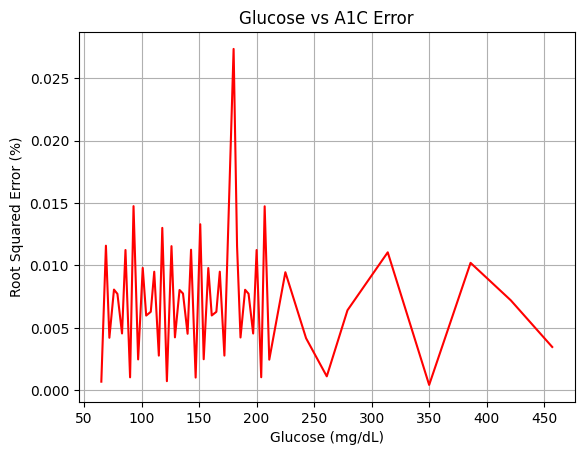

In [8]:
error = np.sqrt((a1c - model_func(glucose, *glucose_a1c_params))**2)
RMSE = np.sqrt(np.mean(error**2))
print(f"Root Mean Squared Error (RMSE): {RMSE:.6f} %")
print(f"Error's Standard Deviation: {np.std(error):.6f} %")
print(f"Error's Uncertainty Percent: {(np.std(error)/RMSE)*100:.6f} %")
plt.plot(glucose, error, label='Error', color='red')
plt.xlabel('Glucose (mg/dL)')
plt.ylabel('Root Squared Error (%)')
plt.title('Glucose vs A1C Error')
plt.grid(True)

## Symbolic Polinomial calculation

In [9]:
# Define the variables
glucose = sp.symbols('glucose')

# Define the coefficients for the polynomial fitting for target PWM
a, b, c = glucose_a1c_params;

# Define the 2rd degree polynomial
a1c = a*glucose**2 + b*glucose + c

# Display the original polynomial
print(f"Ac1:\n {a1c}")


Ac1:
 7.04381208915805e-9*glucose**2 + 0.0280681669271251*glucose + 2.17484707166987


## Polynomial Order Reduction
Remove terms with degrees 2 because on the expected operational range they are not significant compared to the 1fr degree terms.

In [10]:
# Convert to polynomial
poly = sp.Poly(a1c, glucose)

# Remove terms with degrees 4 and 3
coeffs = poly.all_coeffs()
filtered_coeffs = [coeff if i < 2 else 0 for i, coeff in enumerate(reversed(coeffs))]
# Round filtered_coeffs to 4 decimals
round_coeffs = [round(coeff, 4) for coeff in reversed(filtered_coeffs)]
filtered_poly = sp.Poly.from_list(round_coeffs, glucose).as_expr()
print(f"Filtered Coefficients:\n {round_coeffs}")
print(f"======================================\nLineal Order Reduced Glucose to A1C Equation:\n {filtered_poly}\n======================================")

Filtered Coefficients:
 [0, 0.0281, 2.1748]
Lineal Order Reduced Glucose to A1C Equation:
 0.028099*glucose + 2.1748


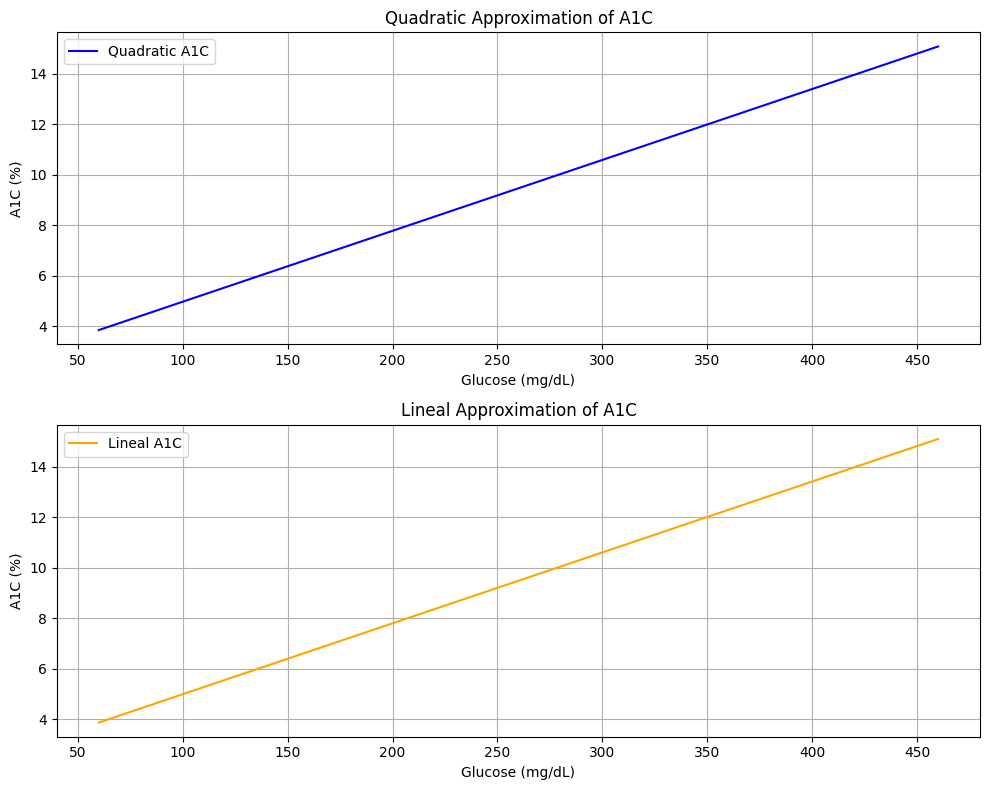

In [11]:
# Generate numerical values for plotting
glucose_values = np.linspace(60, 460, 400)  # Adjust the range and number of points as needed
a1c_values = [a1c.subs(glucose, val) for val in glucose_values]
a1c_values_order_reduced = [filtered_poly.subs(glucose, val) for val in glucose_values]

# Convert delay values to numerical values
a1c_values = [float(val) for val in a1c_values]
a1c_values_order_reduced = [float(val) for val in a1c_values_order_reduced]

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot the simplified polynomial
axs[0].plot(glucose_values, a1c_values, label='Quadratic A1C', color='blue')
axs[0].set_xlabel('Glucose (mg/dL)')
axs[0].set_ylabel('A1C (%)')
axs[0].set_title('Quadratic Approximation of A1C')
axs[0].grid(True)
axs[0].legend()

# Plot the order reduced polynomial
axs[1].plot(glucose_values, a1c_values_order_reduced, label='Lineal A1C', color='orange')
axs[1].set_xlabel('Glucose (mg/dL)')
axs[1].set_ylabel('A1C (%)')
axs[1].set_title('Lineal Approximation of A1C')
axs[1].grid(True)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

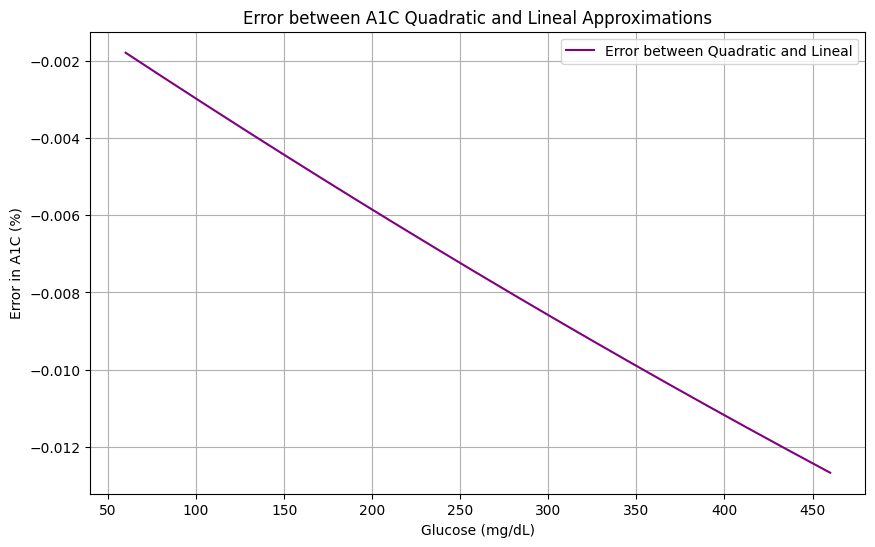

In [12]:
# Calculate the error between the two sets of delay values
error_values = np.array(a1c_values) - np.array(a1c_values_order_reduced)
#error_values = np.abs(np.array(a1c_values) - np.array(a1c_values_order_reduced))

# Create a plot for the error
plt.figure(figsize=(10, 6))
plt.plot(glucose_values, error_values, label='Error between Quadratic and Lineal', color='purple')
plt.xlabel('Glucose (mg/dL)')
plt.ylabel('Error in A1C (%)')
plt.title('Error between A1C Quadratic and Lineal Approximations')
plt.grid(True)
plt.legend()
plt.show()

Root Mean Squared Error (RMSE): 0.008058
Error's Standard Deviation: 0.003153
Error's Uncertainty Percent: 39.132122 %


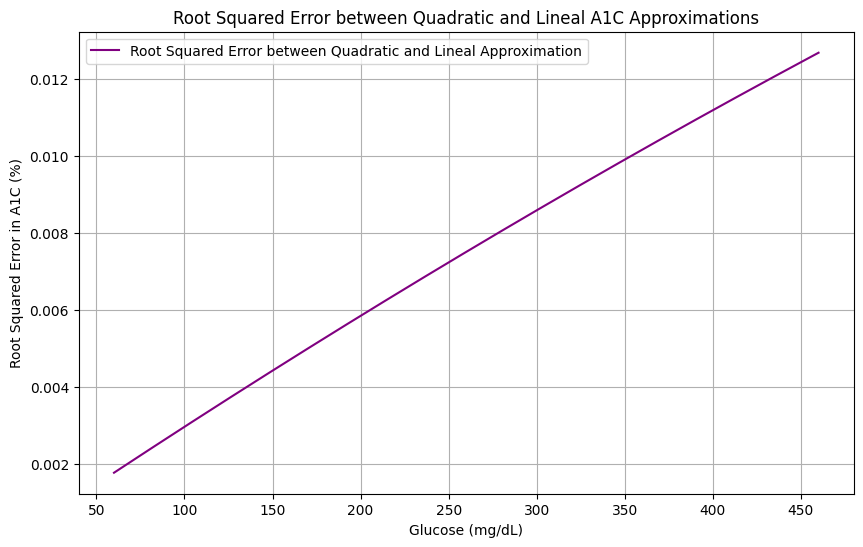

In [13]:
# Calculate the squared error between the two sets of delay values
squared_error_values = (np.array(a1c_values) - np.array(a1c_values_order_reduced))**2

# Calculate the mean squared error
mean_squared_error = np.mean(squared_error_values)

# Calculate the mean squared root error
mean_squared_root_error = np.sqrt(mean_squared_error)

# Calculate the root squared error
root_squared_error_values = np.sqrt(squared_error_values)
# Calculate the standard deviation of the error
error_standard_deviation = np.std(error_values)
# Calculate the uncertainty percent
uncertainty_percent = (error_standard_deviation / mean_squared_root_error) * 100

print(f"Root Mean Squared Error (RMSE): {mean_squared_root_error:.6f}")
print(f"Error's Standard Deviation: {error_standard_deviation:.6f}")
print(f"Error's Uncertainty Percent: {uncertainty_percent:.6f} %")

# Create a plot for the root squared error
plt.figure(figsize=(10, 6))
plt.plot(glucose_values, root_squared_error_values, label='Root Squared Error between Quadratic and Lineal Approximation', color='purple')
plt.xlabel('Glucose (mg/dL)')
plt.ylabel('Root Squared Error in A1C (%)')
plt.title('Root Squared Error between Quadratic and Lineal A1C Approximations')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
# This will remove all variables from the workspace to save memory
%reset -f